In [12]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, plot_precision_recall_curve, plot_roc_curve
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib
import pickle

# ROC/PRC

In [17]:
rf_path = "/mnt/nfs/scratch1/hshukla/final_predictions/"
data_path = "/mnt/nfs/scratch1/hshukla/final_results/"
SECTORS = ["tech", "financials", "consumer", "industrials", "health care", "commodities", "real estate", "utilities", "unavailable"]
jobs = [("freq", None), ("tfidf", None), ("lda",1), ("lda",5), ("lda",7)]

def create_curves(job_type, ws):
    start_year = 2012
    end_year = start_year + 3
    val_year = end_year + 1
    pred_year = val_year + 1
    
    # Load data - remove ineligble rows
    if job_type == "lda":
        test_valid_path = data_path + "data_test_valid_{}_{}_{}.pkl".format(ws, val_year, pred_year)
    else:
        test_valid_path = data_path + "baseline_test_{}_{}.pkl".format(val_year, pred_year)
    data_test_valid = pd.read_pickle(test_valid_path)
    data_test_valid["is_dividend_payer"] = data_test_valid["is_dividend_payer"].astype(bool)
    data_test_valid = data_test_valid[data_test_valid["is_dividend_payer"] & data_test_valid["is_dps_cut"].notnull()]
    data_test_valid["is_dps_cut"] = data_test_valid["is_dps_cut"].astype(int)
    
    # We only need the testing data, not validation. Also pick columns
    data_test = data_test_valid[data_test_valid.year_x == pred_year]
    test_sectors = pd.get_dummies(data_test.sector.str.lower(), prefix="sector", prefix_sep="_").T.reindex(SECTORS).T.fillna(0)
    if job_type == "lda":
        test_weights = pd.concat([data_test, test_sectors], axis=1).loc[:,"risk_topic_0":]
    else:
        if job_type == "freq":
            feature_regex = "freq*"
        elif job_type == "tfidf":
            feature_regex = "tfidf*"
        test_weights = pd.concat([data_test.filter(regex=feature_regex), test_sectors], axis=1)
    
    # Test labels
    test_labels = data_test.loc[:,"is_dps_cut"].to_list()
    
    # Random Forest
    if ws:
        rf_name = "rf_{}_is_dps_cut_{}_{}_{}_{}_{}.joblib".format(job_type, ws, start_year, end_year, val_year, pred_year)
    else:
        rf_name = "rf_{}_is_dps_cut_{}_{}_{}_{}.joblib".format(job_type, start_year, end_year, val_year, pred_year)
    rf = joblib.load(rf_path + rf_name)
    
    # ROC
    roc_disp = plot_roc_curve(rf, test_weights, test_labels)
    roc_disp.ax_.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Random chance', alpha=.8)
    roc_disp.ax_.legend()
    if job_type == "lda":
        plt.title("Sentence-LDA " + str(ws) + " ROC")
    else:
        plt.title("TfIdf ROC")
    plt.savefig(rf_name + "_ROC.png")
    plt.clf()
    
    # PRC
    plot_precision_recall_curve(rf, test_weights, test_labels)
    if job_type == "lda":
        plt.title("Sentence-LDA " + str(ws) + " PRC")
    else:
        plt.title("TfIdf PRC")
    plt.savefig(rf_name + "_PRC.png")
    plt.clf()

In [18]:
create_curves("tfidf", None)

/home/hshukla/anaconda3/envs/harshulEnv/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.0 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/hshukla/anaconda3/envs/harshulEnv/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.0 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [93]:
create_curves("lda", 5)

/home/hshukla/anaconda3/envs/harshulEnv/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.0 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/hshukla/anaconda3/envs/harshulEnv/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.0 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

# F1/Cohen

In [10]:
def avrg(lst):
    return sum(lst) / float(len(lst))

# F1 Score
freq_f1 = [.261, .168, .118]
tfidf_f1 = [.300, .164, .169]
lda_1_f1 = [.244, .177, .149]
lda_5_f1 = [.268, .144, .199]
lda_7_f1 = [.303, .169, .115]

# Cohen-Kappa
freq_ck = [.189, .130, .080]
tfidf_ck = [.243, .118, .104]
lda_1_ck = [.170, .126, .099]
lda_5_ck = [.204, .090, .138]
lda_7_ck = [.242, .104, .075]

In [43]:
f1_scores = list(zip(freq_f1, tfidf_f1, lda_1_f1, lda_5_f1, lda_7_f1))
f1_2017 = list(f1_scores[0])
f1_2018 = list(f1_scores[1])
f1_2019 = list(f1_scores[2])
f1_average = [avrg(freq_f1), avrg(tfidf_f1), avrg(lda_1_f1), avrg(lda_5_f1), avrg(lda_7_f1)]

ck_scores = list(zip(freq_ck, tfidf_ck, lda_1_ck, lda_5_ck, lda_7_ck))
ck_2017 = list(ck_scores[0])
ck_2018 = list(ck_scores[1])
ck_2019 = list(ck_scores[2])

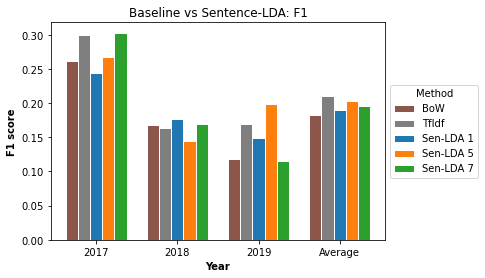

In [72]:
# set width of bars
barWidth = 0.15
 
# Set position of bar on X axis
r1 = np.arange(len(freq_f1) +  1)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
 
# Make the plot
plt.bar(r1, freq_f1 + [avrg(freq_f1)], color='tab:brown', width=barWidth, edgecolor='white', label='BoW')
plt.bar(r2, tfidf_f1 + [avrg(tfidf_f1)], color='tab:gray', width=barWidth, edgecolor='white', label='TfIdf')
plt.bar(r3, lda_1_f1 + [avrg(lda_1_f1)], color='tab:blue', width=barWidth, edgecolor='white', label='Sen-LDA 1')
plt.bar(r4, lda_5_f1 + [avrg(lda_5_f1)], color='tab:orange', width=barWidth, edgecolor='white', label='Sen-LDA 5')
plt.bar(r5, lda_7_f1 + [avrg(lda_7_f1)], color='tab:green', width=barWidth, edgecolor='white', label='Sen-LDA 7')
 
# Add xticks on the middle of the group bars
plt.xlabel('Year', fontweight='bold')
plt.ylabel('F1 score', fontweight='bold')
plt.title("Baseline vs Sentence-LDA: F1")
plt.xticks([r + (2*barWidth) for r in r1], ['2017', '2018', '2019', 'Average'])
 
# Create legend & Show graphic
plt.legend(title="Method", loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("f1.jpg")
plt.show()

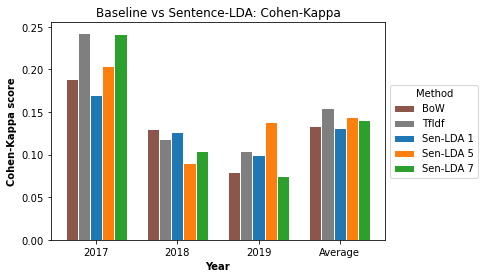

In [71]:
# set width of bars
barWidth = 0.15
 
# Set position of bar on X axis
r1 = np.arange(len(freq_f1) +  1)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
 
# Make the plot
plt.bar(r1, freq_ck + [avrg(freq_ck)], color='tab:brown', width=barWidth, edgecolor='white', label='BoW')
plt.bar(r2, tfidf_ck + [avrg(tfidf_ck)], color='tab:gray', width=barWidth, edgecolor='white', label='TfIdf')
plt.bar(r3, lda_1_ck + [avrg(lda_1_ck)], color='tab:blue', width=barWidth, edgecolor='white', label='Sen-LDA 1')
plt.bar(r4, lda_5_ck + [avrg(lda_5_ck)], color='tab:orange', width=barWidth, edgecolor='white', label='Sen-LDA 5')
plt.bar(r5, lda_7_ck + [avrg(lda_7_ck)], color='tab:green', width=barWidth, edgecolor='white', label='Sen-LDA 7')
 
# Add xticks on the middle of the group bars
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Cohen-Kappa score', fontweight='bold')
plt.title("Baseline vs Sentence-LDA: Cohen-Kappa")
plt.xticks([r + (2*barWidth) for r in r1], ['2017', '2018', '2019', 'Average'])
 
# Create legend & Show graphic
plt.legend(title="Method", loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("Cohen.png")
plt.show()

# Variance

In [19]:
input_path = "/mnt/nfs/scratch1/hshukla/variance_predictions/"

In [71]:
# Load data
variance_lda_1 = pd.read_pickle(input_path + "variance_lda_is_dps_cut_1_2012_2015_2016_2017.pkl")
variance_lda_5 = pd.read_pickle(input_path + "variance_lda_is_dps_cut_5_2012_2015_2016_2017.pkl")
variance_lda_7 = pd.read_pickle(input_path + "variance_lda_is_dps_cut_7_2012_2015_2016_2017.pkl")
variance_freq = pd.read_pickle(input_path + "variance_freq_is_dps_cut_2012_2015_2016_2017.pkl")
variance_tfidf = pd.read_pickle(input_path + "variance_tfidf_is_dps_cut_2012_2015_2016_2017.pkl")

# Zero center
variance_lda_1 = variance_lda_1.apply(lambda x: x-x.mean())
variance_lda_5 = variance_lda_5.apply(lambda x: x-x.mean())
variance_lda_7 = variance_lda_7.apply(lambda x: x-x.mean())
variance_freq = variance_freq.apply(lambda x: x-x.mean())
variance_tfidf = variance_tfidf.apply(lambda x: x-x.mean())

# Labels
variance_lda_1["Method"] = "Sen-LDA 1"
variance_lda_5["Method"] = "Sen-LDA 5"
variance_lda_7["Method"] = "Sen-LDA 7"
variance_freq["Method"] = "BoW"
variance_tfidf["Method"] = "TfIdf"

# Aggr, then use accuracy,f1,coh_kap_score
variance = pd.concat([variance_tfidf, variance_freq, variance_lda_1, variance_lda_5, variance_lda_7], axis=0)
variance.rename(columns={'coh_kap_score':'Cohen Kappa', "f1":"F1", "accuracy":"Accuracy"}, inplace=True)

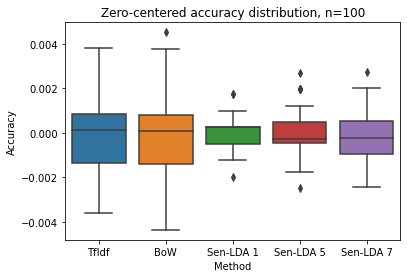

In [85]:
ax = sns.boxplot(x="Method", y="Accuracy", data=variance).set(title='Zero-centered accuracy distribution, n=100')

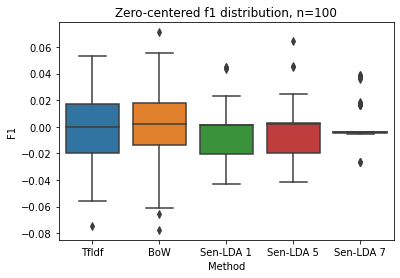

In [86]:
ax = sns.boxplot(x="Method", y="F1", data=variance).set(title='Zero-centered f1 distribution, n=100')

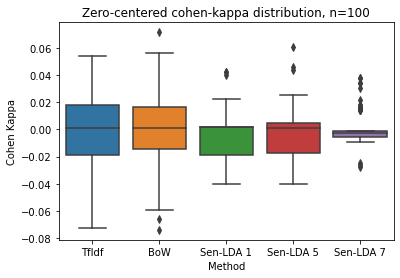

In [87]:
ax = sns.boxplot(x="Method", y="Cohen Kappa", data=variance).set(title='Zero-centered cohen-kappa distribution, n=100')

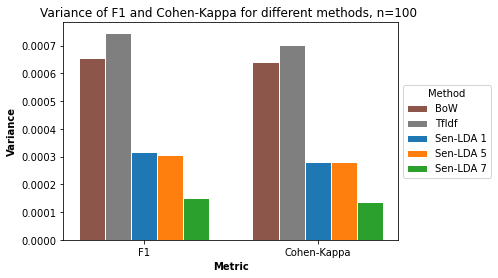

In [101]:
lda_1_var = variance_lda_1.var().to_list()[1:]
lda_5_var = variance_lda_5.var().to_list()[1:]
lda_7_var = variance_lda_7.var().to_list()[1:]
freq_var = variance_freq.var().to_list()[1:]
tfidf_var = variance_tfidf.var().to_list()[1:]

# set width of bars
barWidth = 0.15
 
# Set position of bar on X axis
r1 = np.arange(2)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
 
# Make the plot
plt.bar(r1, freq_var, color='tab:brown', width=barWidth, edgecolor='white', label='BoW')
plt.bar(r2, tfidf_var, color='tab:gray', width=barWidth, edgecolor='white', label='TfIdf')
plt.bar(r3, lda_1_var, color='tab:blue', width=barWidth, edgecolor='white', label='Sen-LDA 1')
plt.bar(r4, lda_5_var, color='tab:orange', width=barWidth, edgecolor='white', label='Sen-LDA 5')
plt.bar(r5, lda_7_var, color='tab:green', width=barWidth, edgecolor='white', label='Sen-LDA 7')
 
# Add xticks on the middle of the group bars
plt.xlabel('Metric', fontweight='bold')
plt.ylabel('Variance', fontweight='bold')
plt.title("Variance of F1 and Cohen-Kappa for different methods, n=100 ")
plt.xticks([r + (2*barWidth) for r in r1], ['F1', 'Cohen-Kappa'])
 
# Create legend & Show graphic
plt.legend(title="Method", loc='center left', bbox_to_anchor=(1, 0.5))
min_acc = min([lda_1_var[0], lda_5_var[0], lda_7_var[0],  freq_var[0], tfidf_var[0]])
plt.show()

In [98]:
lda_1_var

[4.822303105725534e-07, 0.00031659652023934985, 0.0002793726004585026]

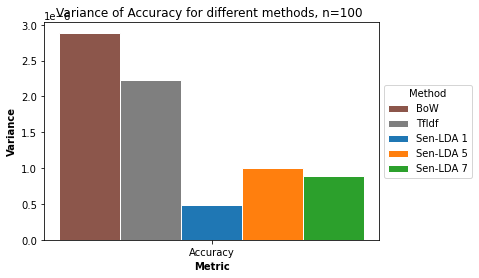

In [104]:
lda_1_var = variance_lda_1.var().to_list()[0]
lda_5_var = variance_lda_5.var().to_list()[0]
lda_7_var = variance_lda_7.var().to_list()[0]
freq_var = variance_freq.var().to_list()[0]
tfidf_var = variance_tfidf.var().to_list()[0]

# set width of bars
barWidth = 0.15
 
# Set position of bar on X axis
r1 = np.arange(1)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
 
# Make the plot
plt.bar(r1, freq_var, color='tab:brown', width=barWidth, edgecolor='white', label='BoW')
plt.bar(r2, tfidf_var, color='tab:gray', width=barWidth, edgecolor='white', label='TfIdf')
plt.bar(r3, lda_1_var, color='tab:blue', width=barWidth, edgecolor='white', label='Sen-LDA 1')
plt.bar(r4, lda_5_var, color='tab:orange', width=barWidth, edgecolor='white', label='Sen-LDA 5')
plt.bar(r5, lda_7_var, color='tab:green', width=barWidth, edgecolor='white', label='Sen-LDA 7')
 
# Add xticks on the middle of the group bars
plt.xlabel('Metric', fontweight='bold')
plt.ylabel('Variance', fontweight='bold')
plt.title("Variance of Accuracy for different methods, n=100 ")
plt.xticks([r + (2*barWidth) for r in r1], ['Accuracy'])
 
# Create legend & Show graphic
plt.legend(title="Method", loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()